In [1]:
import qutip

In [2]:
#example code

#generate a spin ket
N = 3; J = N/2; m = -J
print("Total States: ", 2*J+1)
ket = qutip.spin_state(J,m)
print(ket)


Total States:  4.0
Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]


# Basis States

This problem is difficult to implement in QuTip without running into exponential scaling.

For this first iteration, we're going to run into it. As it's the easiest code to write.

Our basis states for the atoms are $\{\left|u\right>, \left|d\right>, \left|e\right>\}^{N}$.

In [3]:
u = qutip.basis(3,0)
d = qutip.basis(3,1)
e = qutip.basis(3,2)

#print out the basis states
# print("u: ", u)
# print("d: ", d)
# print("e: ", e)

id_atom = qutip.qeye(3)

id_atoms = qutip.tensor(id_atom, id_atom)

Our cavity fock states are $\{0, 1, 2\}$

In [4]:
zero = qutip.basis(3,0)
one = qutip.basis(3,1)
two = qutip.basis(3,2)

id_cav = qutip.qeye(3)

Here we define the single-spin operators `sx`, `sy`, `sz` in terms of $\{\left|u\right>, \left|d\right>\}$.

In [5]:
#create the sx, sy, sz operators on the spin out of the u, d basis

sz = (u*u.dag() - d*d.dag())/2
sx = (u*d.dag() + d*u.dag())/2
sy = (u*d.dag() - d*u.dag())/(2*1j)

#make two atom spin operators
sz = qutip.tensor(sz, id_atom) + qutip.tensor(id_atom, sz)
sx = qutip.tensor(sx, id_atom) + qutip.tensor(id_atom, sx)
sy = qutip.tensor(sy, id_atom) + qutip.tensor(id_atom, sy)

#multiply by the identity on the cavity
sz = qutip.tensor(sz, id_cav)
sx = qutip.tensor(sx, id_cav)
sy = qutip.tensor(sy, id_cav)

Here we define the single-excitation operators for down and up, `nu` and `mu`.

$\nu^\dag = \left| e \right>\left< u \right|$

$\mu^\dag = \left| e \right>\left< d \right|$

In [6]:
nu = u * e.dag()
mu = d * e.dag()

#make two atom excitation operators
nu = qutip.tensor(nu, id_atom) + qutip.tensor(id_atom, nu)
mu = qutip.tensor(mu, id_atom) + qutip.tensor(id_atom, mu)

#multiply by the identity on the cavity
mu = qutip.tensor(mu, id_cav)
nu = qutip.tensor(nu, id_cav)

Here we define the annihilation operator.

In [7]:
a = qutip.destroy(3)

#multiply by the identity on the spins
a = qutip.tensor(id_atoms, a)

Here we define the constants. We'll write everything in terms of 1 scale, the time constant of one of the matrix coefficients.

In [8]:
import numpy as np

Gamma_si = 180e3/2/np.pi
kappa_si = 500e3/2/np.pi
eta = 4
g_si = 2*np.pi*eta*np.sqrt(Gamma_si*kappa_si)/4

#print a coupling constant in engineering notation
print(f"Atom Coupling Constant: {g_si:.2e} rad/s")

Atom Coupling Constant: 3.00e+05 rad/s


In [9]:
omega = 2*np.pi*5e6

print(f"Optical Rabi Frequency: {omega:.2e} rad/s")

Optical Rabi Frequency: 3.14e+07 rad/s


Here we define the rescaled coefficients.

In [10]:
scale = g_si


g = g_si/scale
kappa = kappa_si/scale
Gamma = Gamma_si/scale*0
# omega = omega/scale
omega = kappa*1
# Lambda = 0.1*kappa
detuning = -10*kappa

Lambda = 0.1*kappa*np.sqrt(detuning**2 + 1)
Lambda = 3*Lambda
# Lambda = g
#print parameters
print("g: ", g)
print("Kappa: ", kappa)
print("Gamma: ", Gamma)
print("omega: ", omega)
print("Lambda: ", Lambda)

g:  1.0
Kappa:  0.2652582384864922
Gamma:  0.0
omega:  0.2652582384864922
Lambda:  0.22558765175583867


Here we define the Hamiltonian

In [11]:
def H(t,args):
    try:
        w = args['w']
    except:
        w = 0
    Hpart = g*(a*nu.dag()*np.cos(omega*t)- 1j*a*mu.dag()*np.sin(omega*t)) + Lambda*(np.exp(1j*w*t)*a)

    Ht = Hpart + Hpart.dag()
    return Ht

# Initial State 

In [12]:
dd = qutip.tensor(u+d,u+d)
# dd = qutip.tensor(d,d)
psi0 = qutip.tensor(dd, zero)
rho0 = psi0*psi0.dag()
rho0

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [13]:
id_spin = u*u.dag() + d*d.dag()

id_spin = qutip.tensor(id_spin,id_spin, id_cav)
id_spin

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0

In [14]:
cavity_decay = a*np.sqrt(kappa)
atom_decay = nu*np.sqrt(Gamma)
atom_decay

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [15]:
from qutip import mesolve
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

print(rho0.dims)
print(cavity_decay.dims)
print(atom_decay.dims)
print(sx.dims)
print(sy.dims)
print(sz.dims)

opts = qutip.solver.Options(nsteps=12000)
T = 30
solution = mesolve(
    H=H,
    rho0=rho0,
    tlist=np.linspace(0, T*2*np.pi/kappa, 100),
    c_ops=[cavity_decay],
    e_ops=[sx, sy, sz, sx*sx, sy*sy, sz*sz, id_spin, a.dag()*a],
    args={'w': detuning},
    options=opts,
    progress_bar=TextProgressBar()
)

[[3, 3, 3], [3, 3, 3]]
[[3, 3, 3], [3, 3, 3]]
[[3, 3, 3], [3, 3, 3]]
[[3, 3, 3], [3, 3, 3]]
[[3, 3, 3], [3, 3, 3]]
[[3, 3, 3], [3, 3, 3]]
10.0%. Run time:   1.88s. Est. time left: 00:00:00:16
20.0%. Run time:   3.67s. Est. time left: 00:00:00:14
30.0%. Run time:   5.45s. Est. time left: 00:00:00:12
40.0%. Run time:   7.22s. Est. time left: 00:00:00:10
50.0%. Run time:   9.00s. Est. time left: 00:00:00:08
60.0%. Run time:  10.78s. Est. time left: 00:00:00:07
70.0%. Run time:  12.55s. Est. time left: 00:00:00:05
80.0%. Run time:  14.32s. Est. time left: 00:00:00:03
90.0%. Run time:  16.09s. Est. time left: 00:00:00:01
Total run time:  17.69s


In [16]:
#plot sx*sx

import matplotlib.pyplot as plt

sx, sy, sz, sxx, syy, szz, norm, photons = solution.expect
#elementwise division
sx = sx/norm
sy = sy/norm
sz = sz/norm
sxx = sxx/norm
syy = syy/norm
szz = szz/norm

t = solution.times


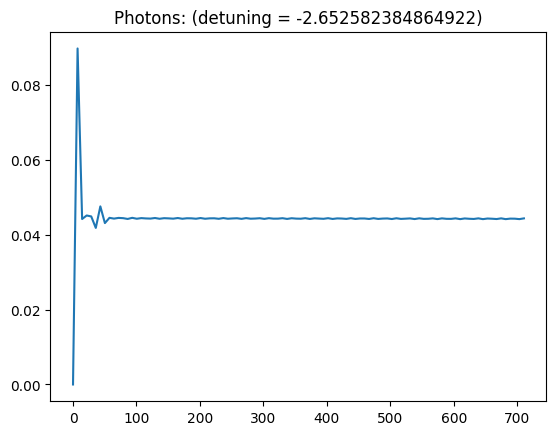

In [17]:
#plot photon number
plt.plot(solution.times, photons);
plt.title(f"Photons: (detuning = {detuning})");

Text(0.5, 1.0, 'Variance (detuning = -2.652582384864922)')

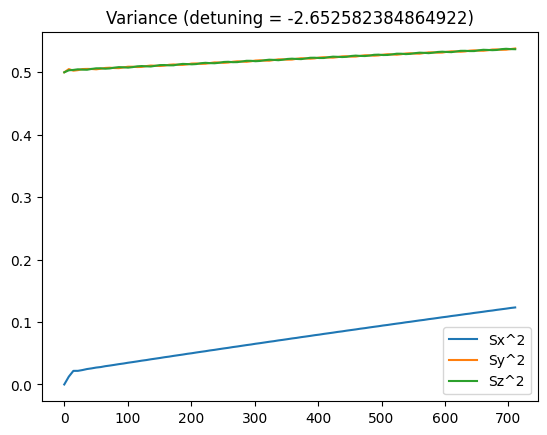

In [18]:
#plot sx variance
plt.plot(t, sxx - sx**2, label="Sx^2");
plt.plot(t, syy - sy**2, label="Sy^2");
plt.plot(t, szz - sz**2, label="Sz^2");
plt.legend();
plt.title(f"Variance (detuning = {detuning})")